Title: Elo & Brier scores in classification problems
Date: 2019-04-13 12:00
Topic: Evaluation Metrics
Slug: nba_elo

The motivation behind this is to discuss the Elo rating system, apply it within an NBA setting, and finally measure the accuracy of predictions (i.e. a team winning a particular regular season game).

Thanks to my instructor, [@MaxHumber](https://speakerdeck.com/maxhumber) for inspiring this post.

---

### Elo

#### Introduction

While I was familiar with the concept of Elo given its usage from [FiveThirtyEight](https://projects.fivethirtyeight.com/complete-history-of-the-nba/#spurs) to measure a basketball team's strength, relative to its peers, I was surprised to find out it was actually derived from chess!

* The Elo rating system is a method for calculating the relative skill levels of players in zero-sum games such as 
chess. It is named after its creator Arpad Elo, a Hungarian-American physics professor (Source: Wikipedia).

Over the years, you can see its extension and adoption to a wide range of use cases, including video games (CounterStrike, League of Legends), and sports (NBA, football, baseball).

<img src="images/elo.svg" alt="elo" class="img-responsive">

Needless to say, it's a very popular framework! Teams always gain Elo points after winning games and lose ground after losing them, in this zero-sum paradigm. Moreover, if you a play stronger opponent and win, then you should be rewarded more points, than if you play weaker opponents and win, and vice versa. Intuitive, right?

---

#### Define Elo Model

The Elo model calculates expected probability of winning of team A, which follows the logistic function.

<img src="images/logistic_curve.svg" alt="logistic">

* Notice that the curve's maximum value is 1.
* This is a common sigmoid curve to use in probabilistic models (approaches 1 and 0, asymptotically)
* The expected score of team A is given as:

#### $$E_A = \frac{1}{1+10^{(R_A-R_B)/400}}$$

<table class="table">
 <thead class="table-responsive table-bordered">
    <tr>
      <th scope="col">NBA Elo Model</th>
      <th scope="col">Description</th>
      <th scope="col">Parameters</th>
      <th scope="col">Value</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Rating of team A</td>
      <td>Elo rating of team A. all teams will start at 1500 for the NBA. This is the long term average.</td>
      <td>$$R_a$$</td>        
      <td>1500</td>
    </tr>
    <tr>
      <td>Rating of team B</td>
      <td>Elo rating of team B</td>
      <td>$$R_b$$</td>
      <td>1500</td>
    </tr>
    <tr>
      <td>Logistic growth rate</td>
      <td> This is the steepness of the curve. For each 400 rating points of advantage over the opponent, the expected probability of winning is 10x in comparison to opponent's expected score (assuming log 10 base) Said another way, a higher g, will require a greater delta between winner's and loser's elo to impact the probability. For the NBA, we will keep this at 400, the level as Chess. </td>
      <td>$$g$$</td>
      <td>400</td>
    </tr>
    <tr>
      <td>K factor</td>
      <td> The k adjustment factor per game based on a win or loss, to penalize under performance and reward over performance. Note, there needs to be a level of stickiness, as you shouldn't lose all of your elo points with one game, and the score retains some memory. According to FiveThirtyEight, and empirical evidence, the optimal K for the NBA to be 20. This is in the same range as the K used for NFL and international soccer elo ratings even though the NBA plays far more games than those sports. In comparison to baseball, this is much higher. It suggests that you should to give a relatively high weight to a team's recent performance. For reference, it's typically 16 for master chess players.
</td>
      <td>$$k$$</td>
      <td>20</td>
    </tr>           
  </tbody>
</table>

**Equation to update a team's elo score after outcome of a game:**

#### $$\begin{align}{R'_A = R_A + K(S_A-E_A)}\end{align}$$

The Score of A is 1 if the team won, else 0 if the team lost.

#### Import Libraries

In [1]:
# data wrangling
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'svg'

import altair as alt
alt.renderers.enable('notebook')

# model evaluation
from sklearn.metrics import accuracy_score, brier_score_loss

# scientific notation off
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.2f}'.format

# blog html visualization 
from IPython.display import HTML

# supress warnings for blog
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

---

#### Data
* [FiveThirtyEight NBA Elo Csv](https://github.com/fivethirtyeight/data/tree/master/nba-elo)

Let's create a class to define a function, `prob`, to calculate the probability of a team winning based on elo,
and define another function, `update`, to update the Elo after the outcome of the game.

In [2]:
class EloTracker:
    def __init__(self, data, start=1500):
        if isinstance(data, dict):
            self.data = data
        if isinstance(data, list):
            self.data = {i: start for i in data}

    # this is the probability of the home team winning
    def prob(self, home, away):
        home_elo, away_elo = self.data[home], self.data[away]
        expected_home = 1 / ( 1 + 10**((away_elo - home_elo)/400))
        expected_away = 1 - expected_home
        return expected_home, expected_away
        
    # update the elo scores
    def update(self, winner, loser, k=20):
        expected_winner, expected_loser = self.prob(winner, loser)
        self.data[winner] = round(self.data[winner] + k*(1 - expected_winner))
        self.data[loser] = round(self.data[loser] + k*(0 - expected_loser))
        return self.data

    def __repr__(self):
        return f'EloTracker({self.data})'

Let's walk through a few examples to familiarize ourselves with elo.

In [3]:
# instantiate all teams at 1500 elo at the beginning of the season
teams = ['Toronto', 'Boston']
elo = EloTracker(teams)
elo.data

{'Toronto': 1500, 'Boston': 1500}

In [4]:
# By definition, teams with the same elo are equally likely to win.
elo.prob('Toronto', 'Boston')

(0.5, 0.5)

In [5]:
# Toronto beats Boston
# Update elo
elo.update('Toronto', 'Boston')
# Toronto gained 10 elo, and Boston lost 10, since this is a zero sum paradigm

{'Toronto': 1510, 'Boston': 1490}

In [6]:
# Fast forward to the end of the season

# End of season, let's assume these elo scores
teams = {'Toronto': 1750, 'Boston': 1500, 'Cleveland': 1250}
elo = EloTracker(teams)
elo.data
toronto_elo_before = elo.data["Toronto"]
elo.update("Toronto", "Cleveland")
toronto_elo_after = elo.data["Toronto"]

print(f' Toronto gained {toronto_elo_after - toronto_elo_before} elo points')
# Because Toronto won against a worst team, they only gained 1 elo points.

 Toronto gained 1 elo points


In [7]:
# Toronto is favoured since it has a higher elo score. 
# But, what if Toronto lost?
teams = {'Toronto': 1750, 'Boston': 1500, 'Cleveland': 1250}
elo = EloTracker(teams)
elo.data
toronto_elo_before = elo.data["Toronto"]
elo.update("Cleveland","Toronto")
toronto_elo_after = elo.data["Toronto"]

print(f' Toronto gained {toronto_elo_after - toronto_elo_before} elo points')
# Because Toronto lost to a worse team, they lost 19 elo points! They were expected to win!

 Toronto gained -19 elo points


---

### Graphs

Let's create some Elo graphs using NBA data to demonstrate this over a season. 

Note, at the beginning of the 2014 season, Elo does not necessarily start at 1500, because in FiveThirtyEight's modelling, there's an idea of a year over year carry over. Instead of resetting each team’s rating when a new season begins, Elo carries over a portion of a team’s rating from one season to the next. This makes sense as good teams tend to remain good rathe than completely regress to the mean after the off season.

In NBA Elo ratings, we keep three-quarters of it. The higher fraction reflects the fact that NBA teams are more consistent from year to year compared to other sports like football. For example, if the Toronto Raptors ended the 2018-19 NBA season with an Elo rating of 1700. The team’s Elo rating for the start of the following season is calculated as follows:

$$0.75 \times 1700 + 0.25 \times 1500 = 1650$$

In [8]:
# data for 2014-2015 NBA season
df = pd.read_csv('./data/nba_elo.csv')
df.head()

# 2014-2015, regular season, home games only, no duplicate record
df = df.query("year_id==2015 & is_playoffs == 0 & _iscopy == 0")

# obtain columns of interest
df = df[['date_game','fran_id', 'pts', 'elo_i', 'opp_fran', 'opp_pts', 'opp_elo_i', 'game_result']].reset_index()

# rename columns
df = df.rename(columns={
    'date_game':'date',
    "fran_id":"home",
    "pts": "pts_home",
    "elo_i": "home_elo",
    "opp_fran":"visitor",
    "opp_pts":"pts_visitor",
    "opp_elo_i":"visitor_elo",
})

df["winner"] = df.apply(lambda row: row.home if row.game_result == "W" else row.visitor, axis=1)

df = df.drop(["index","game_result"],axis=1)

df['date'] = pd.to_datetime(df['date'])
# 1230 games played in 2014-2015
# 30 teams played x 41 home games each 

In [9]:
HTML(df.head().to_html(classes="table table-responsive table-striped table-bordered"))

,date,home,pts_home,home_elo,visitor,pts_visitor,visitor_elo,winner
0,2014-10-28,Lakers,90,1422.00,Rockets,108,1596.46,Rockets
1,2014-10-28,Pelicans,101,1457.22,Magic,84,1359.43,Pelicans
2,2014-10-28,Spurs,101,1699.50,Mavericks,100,1592.01,Spurs
3,2014-10-29,Celtics,121,1378.55,Nets,105,1518.27,Celtics
4,2014-10-29,Hornets,108,1511.00,Bucks,106,1317.85,Hornets


Great, we have a dataframe for each game played, and the elos for each team and the true target ("winner"). Let's graph a few of my favourite matchups. 

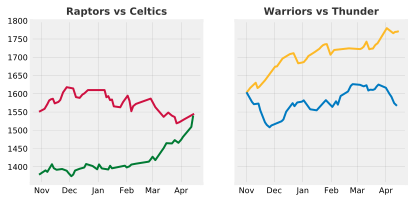

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(6,3),sharex=True, sharey=True)

ax[0].plot(df[df["home"]=="Raptors"].date, df[df["home"]=="Raptors"].home_elo, color='#CE1141',linewidth=2)
ax[0].plot(df[df["home"]=="Celtics"].date, df[df["home"]=="Celtics"].home_elo, color='#007A33',linewidth=2)

ax[0].set_title("Raptors vs Celtics", color = '#000000', alpha=0.8,fontsize=10, fontweight='bold', ha = 'center') 
ax[0].tick_params(labelsize=8)

ax[1].plot(df[df["home"]=="Warriors"].date, df[df["home"]=="Warriors"].home_elo, color='#FDB927',linewidth=2)
ax[1].plot(df[df["home"]=="Thunder"].date, df[df["home"]=="Thunder"].home_elo, color='#007AC1',linewidth=2)

ax[1].set_title("Warriors vs Thunder", color = '#000000', alpha=0.8, fontsize=10, fontweight='bold', ha = 'center') 
ax[1].tick_params(labelsize=8)

ax[0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax[1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%b')
ax[0].xaxis.set_major_formatter(myFmt)
plt.savefig('elo.svg')

Ratings are established on a game-by-game rather than a season-by-season basis. So you can see changes in a team's performance over the course of the year: The Toronto Raptors had a much higher rating early in the 2014-15 season than at the end of it, while the reverse has been true for the Boston Celtics, who gained momentum going into the playoffs.

Remember teams are average with 1500 Elo (41W and 41L). The Raptors, Celtics and Thunder 1550+ and are playoff bound. With an Elo of 1750+, the Warriors are a true title contender!

---
### Establish Baseline

#### Naive Model
Establishing a naive model is important to see how our model improves against a benchmark. 
Let's create naive model, by predicting that the home team always wins. How accurate are we?

In [11]:
y = df['winner'] # true y
y_hat = df['home'] # predict winner based on home team winning
accuracy_score(y, y_hat)

0.5747967479674797

We are 57.5% accurate by just picking the home team to win. Hey, it's better than a coin flip, but can we do better?

---
### Introducing the Brier Score

#### $$\frac{1}{N}\sum\limits _{i=1}^{N}(p_i-o_i)^2$$

By definition, the Brier score measures the mean squared difference between the predicted probability $p_i$ assigned to the possible outcomes $o_i$ for all i and the actual outcome. 

Mathematically, the Brier score always takes on a value between zero and one, since this is the largest possible difference between a predicted probability (which must be between zero and one) and the actual outcome (which can take on values of only 0 and 1). 

Roughly speaking, the Brief score mimics a MSE for regression problems in the classification case, such as predicting binary outcomes. Therefore, the lower the Brier score is for a set of predictions, the better the predictions are **calibrated.**

Like the Elo, it penalizes wrong predictions heavily when you are sure of an outcome (e.g. upsets in sports). This is not necessarily captured in accuracy, so it is a good supplement metric when evaluating models. 

In other words, it calibrates the predictions. You predicted that good teams when they SHOULD win, and predicted that losses when they SHOULD lose. When you were unsure, it SHOULD be a coin toss! That is a good model.

#### Naive Model: Brier Score
To calculate the Brier score we need the true probabilities and the predicted probabilities

In [12]:
# true y
# 100% for correct prediction
# 0% for incorrect prediction
df["y"] = df.apply(lambda row: 1 if row.home == row.winner else 0,axis=1)
y = df["y"]

In [13]:
# y_prob is the probability of winning for home team 
# probability of winning is 100% if you're home and if you're 0% away
df['predict_home_win'] = np.ones(len(y))
y_prob = df.predict_home_win

brier_score_loss(y, y_prob, pos_label=1)

0.42520325203252035

---
### Elo Model
What if we tried to be smarter? Are we able to create a model with Elo that is more accurate?

In [14]:
# calculate the probability of winning for the home team using elo
def prob(home_elo, away_elo):
    expected_home = 1 / ( 1 + 10**((away_elo - home_elo)/400) )
    expected_away = 1 - expected_home
    return expected_home, expected_away

In [15]:
df['predict_home_elo_win'] = df.apply(lambda row: prob(row.home_elo, row.visitor_elo)[0], axis=1)

In [16]:
# predict home win if % is greater than 50%
df['predict_elo'] = np.where(df.predict_home_elo_win >= 0.5, df.home, df.visitor)

In [17]:
y = df['winner'] # true y
y_hat = df.predict_elo  # predict winner based on home team winning
y_prob = df.predict_home_elo_win # probability of home team winning
accuracy_score(y, y_hat)
# so, predicting on elo, is 67% accurate! This is already better than only predicting the home team.

0.6707317073170732

#### Elo Model: Brier Score

In [18]:
# To calculate the Brier score we need the true probabilities and the predicted probabilities
# true y
y = df["y"]

# y_prob is the probability of winning for home team
y_prob = df["predict_home_elo_win"]

brier_score_loss(y, y_prob, pos_label=1) 

0.21094193773599698

<table class="table">
<thead class="table-responsive table-striped">
<tr>
<th>Metric</th>
<th>Prediction based on Home</th>
<th>Prediction based on Elo</th>
<th>Delta</th>
</tr>
<tbody>
<tr>
<td>Accuracy</td>
<td>58%</td>
<td>67%</td>
<td>+9%</td>
</tr>
<tr>
<td>Brier Score</td>
<td>43%</td>
<td>21%</td>
<td>+22%</td>
</tr>
</tbody>
</table>

Not only was the Elo model more accurate than naive model, it has a lower brier score, which suggests its predictions were better forecast.

In this particular dataset, accuracy was able to pick up the model improvement, but when I used on a different data set (e.g. NHL), this was not the case. Brier score is able to pick up improvements that may otherwise be masked.

Along side typical metrics such as accuracy, and area under the curve, now you can be armed with another tool to evaluate your models!

---
### Margin of Safety & NBA Upsets

Suppose you wanted to only make predictions on games you were certain of the outcome. You could introduce a margin of safety, such that you would only predict wins on games greater than 70%.

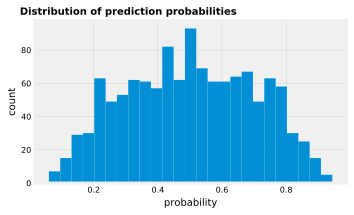

In [19]:
plt.figure(figsize = (5,3))
plt.title("Distribution of prediction probabilities", fontsize=10, fontweight="bold", position = (0.3,1))
plt.hist(df.predict_home_elo_win, bins=25);
plt.xlabel('probability', fontsize=10)
plt.ylabel('count', fontsize=10)
plt.tick_params(labelsize=8)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# win probabilities are distributed about 50% but more parity than I expected

In [29]:
margin_of_safety = df[df.predict_home_elo_win > 0.70]
HTML(margin_of_safety.head().to_html(classes="table table-responsive table-striped table-bordered"))

,date,home,pts_home,home_elo,visitor,pts_visitor,visitor_elo,winner,y,predict_home_win,predict_home_elo_win,predict_elo
4,2014-10-29,Hornets,108,1511.00,Bucks,106,1317.85,Hornets,1,1.00,0.75,Hornets
6,2014-10-29,Pacers,103,1532.67,Sixers,91,1316.42,Pacers,1,1.00,0.78,Pacers
10,2014-10-29,Suns,119,1560.12,Lakers,99,1410.66,Suns,1,1.00,0.70,Suns
16,2014-10-30,Mavericks,120,1590.40,Jazz,102,1367.04,Mavericks,1,1.00,0.78,Mavericks
29,2014-11-01,Warriors,127,1602.86,Lakers,104,1400.48,Warriors,1,1.00,0.76,Warriors


In [21]:
y = margin_of_safety.winner
y_hat = margin_of_safety.predict_elo
y_prob = margin_of_safety.predict_home_elo_win
brier_score_loss(y, y_prob, pos_label=1)
accuracy_score(y, y_hat)

0.8375

As you would expect, the accuracy for this model is quite good. Out of these 240 games, with a heavy favourite, only 16.25% of them were upsets. Anything can happen in the NBA! 

Let's plot this relationship, accuracy vs. margin of safety.

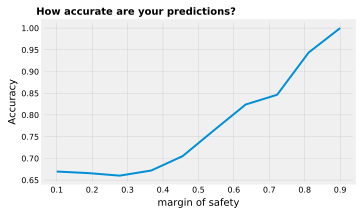

In [22]:
plt.figure(figsize = (5,3))

def my_plot(): 
    margin = np.linspace(0.1,0.90,10)
    my_dict = {}
    for i in margin:
        safe = df[df.predict_home_elo_win > i]
        y = safe.winner
        y_hat = safe.predict_elo
        y_prob = safe.predict_home_elo_win
        brier_score_loss(y, y_prob, pos_label=1)
        my_dict[i] = accuracy_score(y, y_hat)
    return my_dict
    
plt.plot(list(my_plot().keys()), list(my_plot().values()),linewidth=2)

plt.title("How accurate are your predictions?", fontsize=10, fontweight = "bold", position = (0.3,1))
plt.xlabel('margin of safety', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.tick_params(labelsize=8)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

As your margin of safety increases, so does your accuracy %. If you want to be 100% accuracy, then you should only predict on games that are at least 90% probable. However, as you increase this threshold, the number of games you're predicting on becomes smaller. If you were a gambler, that wouldn't be a lot of fun. I guess, that's why there's spreads ;)

Also, the trend is pretty smooth, so the occurrences of upsets from the Elo model are not clustered around any specific threshold, which is desired.

In summary, Elo is a fantastic method for calculating the relative skill levels of players in zero-sum games, whereas and brier scores is a metric that measures the accuracy of probabilistic predictions, which accuracy alone may not catch!

I highly recommend you to explore both, to see how you could incorporate them into your workflow.

---
### Reference and Further Reading

* [Elo rating system](https://en.wikipedia.org/wiki/Elo_rating_system)
* [Complete history of the NBA - Elo](https://projects.fivethirtyeight.com/complete-history-of-the-nba/#raptors)
* [How FiveThirtyEight calculates elo ratings](https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/)
* [Brier Score](https://en.wikipedia.org/wiki/Brier_score)